# Flirt Detection Model - Training, Validation, and Testing

This notebook covers the complete pipeline for training, validating, and testing the DistilBERT-based flirt detection model.

## Overview
- **Model**: DistilBERT with custom classification head
- **Task**: Binary classification (Flirt vs Non-Flirt)
- **Dataset**: Processed detection data (train/val/test splits)
- **Goal**: Achieve >80% accuracy


## 1. Setup and Imports


In [9]:
import os
import sys
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

# PyTorch imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from tqdm import tqdm
from transformers import get_linear_schedule_with_warmup

# Scikit-learn for metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

# Add src to path - resolve detection module location
current_dir = Path(os.getcwd())
src_path = None

# Try to find src/detection directory
candidates = [
    current_dir / 'src',  # If notebook is in flirt-detection/
    current_dir.parent / 'flirt-detection' / 'src',  # If running from project root
    Path(__file__).parent / 'src' if '__file__' in globals() else None,  # If running as script
]

for candidate in candidates:
    if candidate and (candidate / 'detection' / 'model.py').exists():
        src_path = candidate.resolve()
        break

if src_path is None:
    # Fallback: use current_dir/src
    src_path = (current_dir / 'src').resolve()

# Add to Python path
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

# Set project root for data paths
project_root = src_path.parent.parent if 'flirt-detection' in str(src_path) else src_path.parent

# Import model (IDE may show warning but works at runtime)
from detection.model import FlirtDetectionModel, FlirtDetectionTokenizer, count_parameters  # type: ignore

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")


Using device: cpu
PyTorch version: 2.9.0


## 2. Load and Explore Data


In [10]:
# Load data from CSV files
data_dir = project_root / 'data' / 'processed'

train_df = pd.read_csv(data_dir / 'detection_train.csv')
val_df = pd.read_csv(data_dir / 'detection_val.csv')
test_df = pd.read_csv(data_dir / 'detection_test.csv')

# Display dataset sizes
print("="*60)
print("DATASET SUMMARY")
print("="*60)
print(f"Training samples: {len(train_df):,}")
print(f"Validation samples: {len(val_df):,}")
print(f"Test samples: {len(test_df):,}")
print(f"Total samples: {len(train_df) + len(val_df) + len(test_df):,}")
print("="*60)

# Label distributions
print("\nTraining label distribution:")
train_dist = train_df['label'].value_counts().sort_index()
print(train_dist)
print(f"Class balance: {train_dist[0]/(train_dist[0]+train_dist[1]):.2%} / {train_dist[1]/(train_dist[0]+train_dist[1]):.2%}")

print("\nValidation label distribution:")
val_dist = val_df['label'].value_counts().sort_index()
print(val_dist)
print(f"Class balance: {val_dist[0]/(val_dist[0]+val_dist[1]):.2%} / {val_dist[1]/(val_dist[0]+val_dist[1]):.2%}")

print("\nTest label distribution:")
test_dist = test_df['label'].value_counts().sort_index()
print(test_dist)
print(f"Class balance: {test_dist[0]/(test_dist[0]+test_dist[1]):.2%} / {test_dist[1]/(test_dist[0]+test_dist[1]):.2%}")


DATASET SUMMARY
Training samples: 2,599
Validation samples: 557
Test samples: 558
Total samples: 3,714

Training label distribution:
label
0.0    1299
1.0    1300
Name: count, dtype: int64
Class balance: 49.98% / 50.02%

Validation label distribution:
label
0.0    279
1.0    278
Name: count, dtype: int64
Class balance: 50.09% / 49.91%

Test label distribution:
label
0.0    279
1.0    279
Name: count, dtype: int64
Class balance: 50.00% / 50.00%


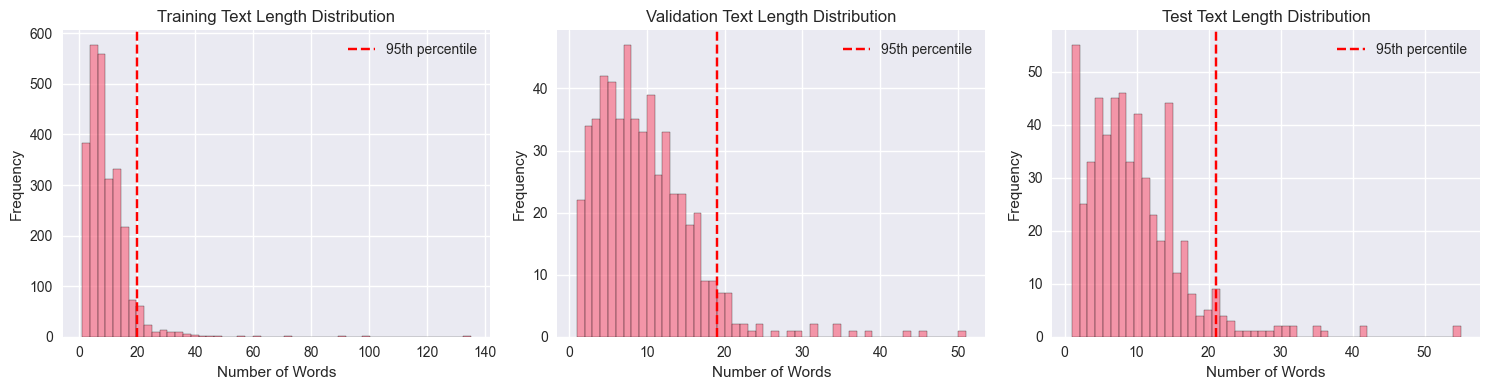

Training - Mean: 9.5, Median: 8.0, 95th percentile: 20.0
Validation - Mean: 9.2, Median: 8.0, 95th percentile: 19.0
Test - Mean: 9.7, Median: 8.0, 95th percentile: 21.0

Sample training texts:
Not Flirt: i’m chillin just stuck at home like everyone else lol. v boring
Flirt: i walked by today and remembered the last time we were there
Flirt: 😜
Flirt: so how have u been?
Flirt: omg you better be jerking off.


In [11]:
# Explore text lengths
train_lengths = [len(text.split()) for text in train_df['text']]
val_lengths = [len(text.split()) for text in val_df['text']]
test_lengths = [len(text.split()) for text in test_df['text']]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].hist(train_lengths, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Training Text Length Distribution')
axes[0].set_xlabel('Number of Words')
axes[0].set_ylabel('Frequency')
axes[0].axvline(np.percentile(train_lengths, 95), color='r', linestyle='--', label='95th percentile')
axes[0].legend()

axes[1].hist(val_lengths, bins=50, edgecolor='black', alpha=0.7)
axes[1].set_title('Validation Text Length Distribution')
axes[1].set_xlabel('Number of Words')
axes[1].set_ylabel('Frequency')
axes[1].axvline(np.percentile(val_lengths, 95), color='r', linestyle='--', label='95th percentile')
axes[1].legend()

axes[2].hist(test_lengths, bins=50, edgecolor='black', alpha=0.7)
axes[2].set_title('Test Text Length Distribution')
axes[2].set_xlabel('Number of Words')
axes[2].set_ylabel('Frequency')
axes[2].axvline(np.percentile(test_lengths, 95), color='r', linestyle='--', label='95th percentile')
axes[2].legend()

plt.tight_layout()
plt.show()

print(f"Training - Mean: {np.mean(train_lengths):.1f}, Median: {np.median(train_lengths):.1f}, 95th percentile: {np.percentile(train_lengths, 95):.1f}")
print(f"Validation - Mean: {np.mean(val_lengths):.1f}, Median: {np.median(val_lengths):.1f}, 95th percentile: {np.percentile(val_lengths, 95):.1f}")
print(f"Test - Mean: {np.mean(test_lengths):.1f}, Median: {np.median(test_lengths):.1f}, 95th percentile: {np.percentile(test_lengths, 95):.1f}")

# Sample data
print("\nSample training texts:")
for i in range(5):
    label_str = "Flirt" if train_df.iloc[i]['label'] == 1.0 else "Not Flirt"
    print(f"{label_str}: {train_df.iloc[i]['text']}")


## 3. Create Dataset and DataLoaders


In [12]:
class FlirtDataset(Dataset):
    """Dataset class for flirt detection"""
    
    def __init__(self, texts: List[str], labels: List[int], tokenizer: FlirtDetectionTokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])
        
        # Tokenize
        encoding = self.tokenizer.encode_single(text)
        
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Initialize tokenizer
MAX_LENGTH = 128  # Based on text length analysis
tokenizer = FlirtDetectionTokenizer(max_length=MAX_LENGTH)

# Create datasets
train_texts = train_df['text'].tolist()
train_labels = train_df['label'].astype(int).tolist()

val_texts = val_df['text'].tolist()
val_labels = val_df['label'].astype(int).tolist()

test_texts = test_df['text'].tolist()
test_labels = test_df['label'].astype(int).tolist()

train_dataset = FlirtDataset(train_texts, train_labels, tokenizer)
val_dataset = FlirtDataset(val_texts, val_labels, tokenizer)
test_dataset = FlirtDataset(test_texts, test_labels, tokenizer)

# Create data loaders
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")


Train batches: 163
Val batches: 35
Test batches: 35


## 4. Initialize Model


In [13]:
# Model hyperparameters
MODEL_NAME = "distilbert-base-uncased"
NUM_LABELS = 2
DROPOUT = 0.3
FREEZE_BERT = False

# Initialize model
model = FlirtDetectionModel(
    model_name=MODEL_NAME,
    num_labels=NUM_LABELS,
    dropout=DROPOUT,
    freeze_bert=FREEZE_BERT
)

model = model.to(device)

# Count parameters
trainable_params, total_params = count_parameters(model)
print(f"Trainable parameters: {trainable_params:,}")
print(f"Total parameters: {total_params:,}")
print(f"Model size: {total_params * 4 / 1024 / 1024:.2f} MB (assuming float32)")


Trainable parameters: 66,364,418
Total parameters: 66,364,418
Model size: 253.16 MB (assuming float32)


## 5. Training Functions


In [14]:
def train_epoch(model, dataloader, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    progress_bar = tqdm(dataloader, desc="Training")
    for batch in progress_bar:
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Statistics
        total_loss += loss.item()
        preds = torch.argmax(outputs['logits'], dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        # Update progress bar
        progress_bar.set_postfix({'loss': loss.item()})
    
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    
    return avg_loss, accuracy


def validate(model, dataloader, device):
    """Validate model"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc="Validation")
        for batch in progress_bar:
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs['loss']
            
            # Statistics
            total_loss += loss.item()
            preds = torch.argmax(outputs['logits'], dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    
    return avg_loss, accuracy, precision, recall, f1, all_preds, all_labels


## 6. Training Loop


In [15]:
# Training hyperparameters
LEARNING_RATE = 2e-5
NUM_EPOCHS = 5
WEIGHT_DECAY = 0.01
EARLY_STOPPING_PATIENCE = 3

# Initialize optimizer
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler (optional)
total_steps = len(train_loader) * NUM_EPOCHS
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=warmup_steps, 
    num_training_steps=total_steps
) if warmup_steps > 0 else None

# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_precision': [],
    'val_recall': [],
    'val_f1': []
}

# Training loop
best_val_acc = 0.0
patience_counter = 0
best_model_state = None

print("Starting training...")
print(f"Training for {NUM_EPOCHS} epochs")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Device: {device}\n")

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch}/{NUM_EPOCHS}")
    print(f"{'='*60}")
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device)
    if scheduler:
        scheduler.step()
    
    # Validate
    val_loss, val_acc, val_precision, val_recall, val_f1, _, _ = validate(model, val_loader, device)
    
    # Update history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_precision'].append(val_precision)
    history['val_recall'].append(val_recall)
    history['val_f1'].append(val_f1)
    
    # Print metrics
    print(f"\nTrain Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print(f"Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}")
    
    # Early stopping and checkpointing
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        best_model_state = model.state_dict().copy()
        print(f"✓ New best validation accuracy: {best_val_acc:.4f}")
    else:
        patience_counter += 1
        if patience_counter >= EARLY_STOPPING_PATIENCE:
            print(f"\nEarly stopping triggered after {epoch} epochs")
            model.load_state_dict(best_model_state)
            break

print(f"\n{'='*60}")
print("Training completed!")
print(f"Best validation accuracy: {best_val_acc:.4f}")
print(f"{'='*60}")


Starting training...
Training for 5 epochs
Learning rate: 2e-05
Batch size: 16
Device: cpu


Epoch 1/5


Validation: 100%|██████████| 35/35 [00:20<00:00,  1.72it/s]



Train Loss: 0.7426, Train Acc: 0.5098
Val Loss: 0.7044, Val Acc: 0.5081
Val Precision: 0.6157, Val Recall: 0.5081, Val F1: 0.3608
✓ New best validation accuracy: 0.5081

Epoch 2/5


Validation: 100%|██████████| 35/35 [00:18<00:00,  1.86it/s]



Train Loss: 0.7073, Train Acc: 0.5487
Val Loss: 0.6597, Val Acc: 0.5835
Val Precision: 0.6768, Val Recall: 0.5835, Val F1: 0.5208
✓ New best validation accuracy: 0.5835

Epoch 3/5


Validation: 100%|██████████| 35/35 [00:23<00:00,  1.52it/s]



Train Loss: 0.6661, Train Acc: 0.5925
Val Loss: 0.6013, Val Acc: 0.7074
Val Precision: 0.7147, Val Recall: 0.7074, Val F1: 0.7049
✓ New best validation accuracy: 0.7074

Epoch 4/5


Validation: 100%|██████████| 35/35 [00:24<00:00,  1.46it/s]



Train Loss: 0.5924, Train Acc: 0.6830
Val Loss: 0.4998, Val Acc: 0.7882
Val Precision: 0.7885, Val Recall: 0.7882, Val F1: 0.7881
✓ New best validation accuracy: 0.7882

Epoch 5/5


Validation: 100%|██████████| 35/35 [00:19<00:00,  1.77it/s]


Train Loss: 0.4886, Train Acc: 0.7591
Val Loss: 0.4261, Val Acc: 0.8007
Val Precision: 0.8024, Val Recall: 0.8007, Val F1: 0.8004
✓ New best validation accuracy: 0.8007

Training completed!
Best validation accuracy: 0.8007


## 7. Visualize Training Curves


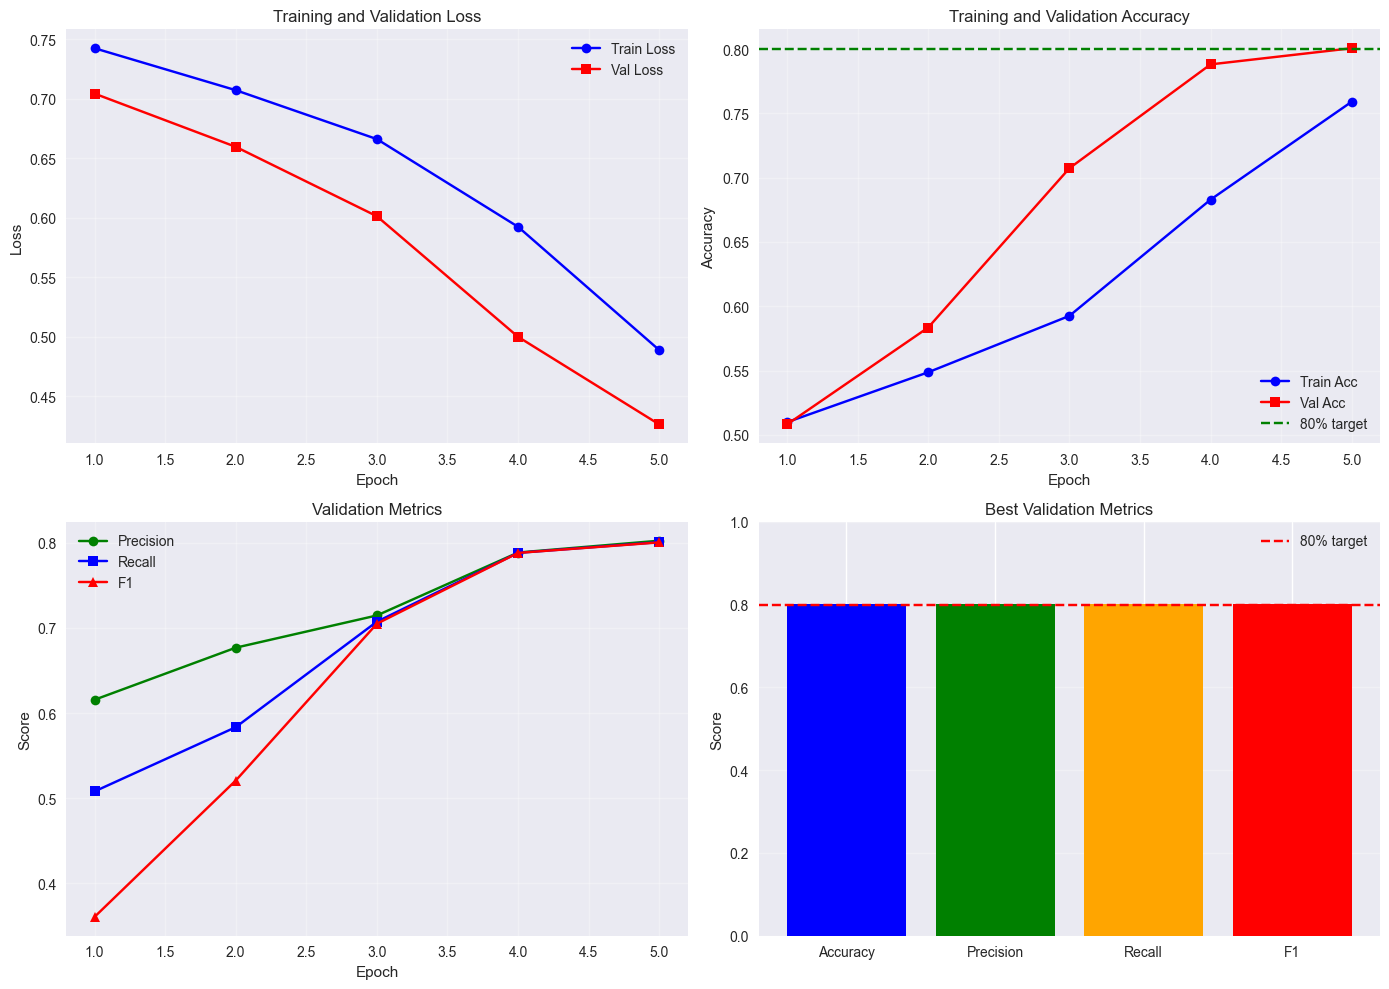

In [21]:
# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

epochs = range(1, len(history['train_loss']) + 1)

# Loss
axes[0, 0].plot(epochs, history['train_loss'], 'b-o', label='Train Loss')
axes[0, 0].plot(epochs, history['val_loss'], 'r-s', label='Val Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Accuracy
axes[0, 1].plot(epochs, history['train_acc'], 'b-o', label='Train Acc')
axes[0, 1].plot(epochs, history['val_acc'], 'r-s', label='Val Acc')
axes[0, 1].axhline(0.80, color='g', linestyle='--', label='80% target')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Training and Validation Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Validation metrics
axes[1, 0].plot(epochs, history['val_precision'], 'g-o', label='Precision')
axes[1, 0].plot(epochs, history['val_recall'], 'b-s', label='Recall')
axes[1, 0].plot(epochs, history['val_f1'], 'r-^', label='F1')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_title('Validation Metrics')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Best metrics bar chart
best_metrics = {
    'Accuracy': max(history['val_acc']),
    'Precision': max(history['val_precision']),
    'Recall': max(history['val_recall']),
    'F1': max(history['val_f1'])
}
axes[1, 1].bar(best_metrics.keys(), best_metrics.values(), color=['blue', 'green', 'orange', 'red'])
axes[1, 1].axhline(0.80, color='r', linestyle='--', label='80% target')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Best Validation Metrics')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


## 8. Evaluate on Test Set


In [22]:
# Evaluate on test set
print("Evaluating on test set...")
test_loss, test_acc, test_precision, test_recall, test_f1, test_preds, test_labels = validate(model, test_loader, device)

print(f"\n{'='*60}")
print("TEST SET RESULTS")
print(f"{'='*60}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1: {test_f1:.4f}")
print(f"{'='*60}")

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
print("\nConfusion Matrix:")
print(f"                Predicted")
print(f"              Class 0  Class 1")
print(f"Actual Class 0   {cm[0,0]:4d}    {cm[0,1]:4d}")
print(f"         Class 1   {cm[1,0]:4d}    {cm[1,1]:4d}")

# Classification report
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=['Not Flirt', 'Flirt']))

# Check if accuracy meets requirement
if test_acc >= 0.80:
    print(f"\n✓ Model meets accuracy requirement (>=80%): {test_acc:.2%}")
else:
    print(f"\n✗ Model does not meet accuracy requirement (>=80%): {test_acc:.2%}")


Evaluating on test set...


Validation: 100%|██████████| 35/35 [00:43<00:00,  1.24s/it]


TEST SET RESULTS
Test Loss: 0.4197
Test Accuracy: 0.7867
Test Precision: 0.7903
Test Recall: 0.7867
Test F1: 0.7861

Confusion Matrix:
                Predicted
              Class 0  Class 1
Actual Class 0    235      44
         Class 1     75     204

Classification Report:
              precision    recall  f1-score   support

   Not Flirt       0.76      0.84      0.80       279
       Flirt       0.82      0.73      0.77       279

    accuracy                           0.79       558
   macro avg       0.79      0.79      0.79       558
weighted avg       0.79      0.79      0.79       558


✗ Model does not meet accuracy requirement (>=80%): 78.67%


## 9. Visualize Test Results


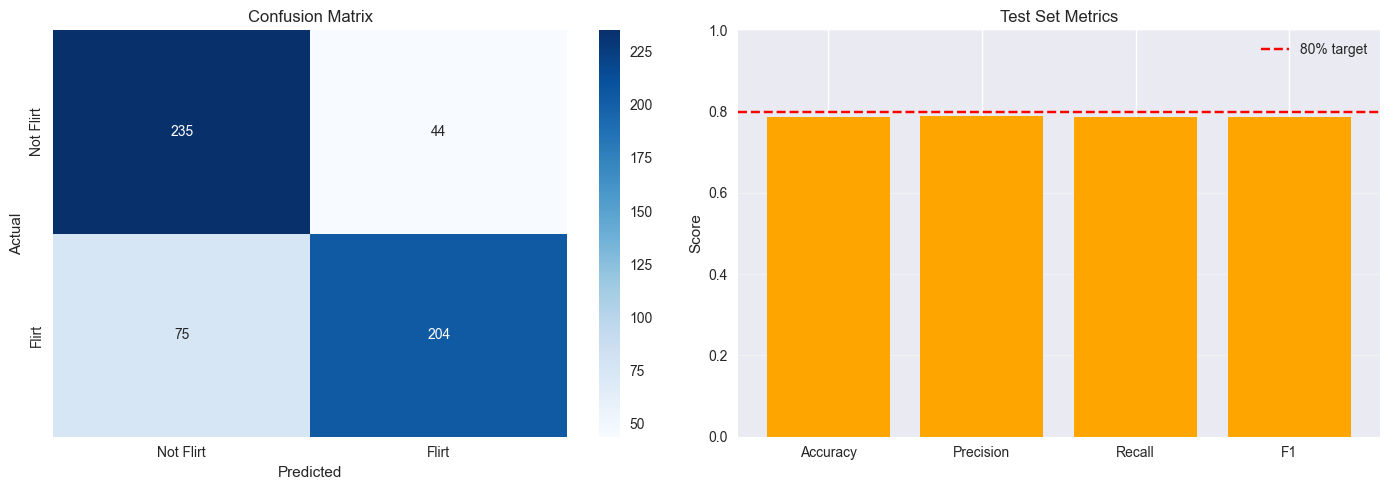

In [18]:
# Plot confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion matrix heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Not Flirt', 'Flirt'],
            yticklabels=['Not Flirt', 'Flirt'])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix')

# Metrics bar chart
metrics = {
    'Accuracy': test_acc,
    'Precision': test_precision,
    'Recall': test_recall,
    'F1': test_f1
}
colors = ['green' if v >= 0.80 else 'orange' for v in metrics.values()]
axes[1].bar(metrics.keys(), metrics.values(), color=colors)
axes[1].axhline(0.80, color='r', linestyle='--', label='80% target')
axes[1].set_ylabel('Score')
axes[1].set_title('Test Set Metrics')
axes[1].set_ylim(0, 1)
axes[1].legend()
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


## 10. Save Model and Results


In [19]:
# Create model directory
model_dir = project_root / 'flirt-detection' / 'models'
model_dir.mkdir(exist_ok=True, parents=True)

# Save model
model_path = model_dir / 'flirt_detection_model.pt'
model.save_model(str(model_path))
print(f"Model saved to {model_path}")

# Save training history
history_path = model_dir / 'training_history.json'
with open(history_path, 'w') as f:
    json.dump(history, f, indent=2)
print(f"Training history saved to {history_path}")

# Save test results
test_results = {
    'test_loss': float(test_loss),
    'test_accuracy': float(test_acc),
    'test_precision': float(test_precision),
    'test_recall': float(test_recall),
    'test_f1': float(test_f1),
    'confusion_matrix': cm.tolist(),
    'best_val_accuracy': float(best_val_acc)
}
results_path = model_dir / 'test_results.json'
with open(results_path, 'w') as f:
    json.dump(test_results, f, indent=2)
print(f"Test results saved to {results_path}")

# Save hyperparameters
hyperparams = {
    'model_name': MODEL_NAME,
    'num_labels': NUM_LABELS,
    'dropout': DROPOUT,
    'freeze_bert': FREEZE_BERT,
    'max_length': MAX_LENGTH,
    'batch_size': BATCH_SIZE,
    'learning_rate': LEARNING_RATE,
    'num_epochs': NUM_EPOCHS,
    'weight_decay': WEIGHT_DECAY,
    'early_stopping_patience': EARLY_STOPPING_PATIENCE
}
hyperparams_path = model_dir / 'hyperparameters.json'
with open(hyperparams_path, 'w') as f:
    json.dump(hyperparams, f, indent=2)
print(f"Hyperparameters saved to {hyperparams_path}")


Model saved to /Users/madinadairova/Desktop/flirtio/flirt-detection/models/flirt_detection_model.pt
Model saved to /Users/madinadairova/Desktop/flirtio/flirt-detection/models/flirt_detection_model.pt
Training history saved to /Users/madinadairova/Desktop/flirtio/flirt-detection/models/training_history.json
Test results saved to /Users/madinadairova/Desktop/flirtio/flirt-detection/models/test_results.json
Hyperparameters saved to /Users/madinadairova/Desktop/flirtio/flirt-detection/models/hyperparameters.json


## 11. Example Predictions


In [20]:
# Test on some example texts
example_texts = [
    "Hey, how are you?",
    "You're so beautiful",
    "What's the weather like today?",
    "I want to see you",
    "Can we meet tomorrow?",
    "You're killing me with these sexy selfies",
    "Let's grab coffee sometime",
    "I miss you so much",
]

model.eval()
predictions = []
probabilities = []

for text in example_texts:
    encoding = tokenizer.encode_single(text)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        probs = model.predict_proba(input_ids, attention_mask)
        pred = model.predict(input_ids, attention_mask)
    
    predictions.append(pred.item())
    probabilities.append(probs.cpu().numpy()[0])

# Display results
print("Example Predictions:")
print("="*80)
for text, pred, prob in zip(example_texts, predictions, probabilities):
    label = "Flirt" if pred == 1 else "Not Flirt"
    prob_flirt = prob[1]
    prob_not_flirt = prob[0]
    print(f"\nText: \"{text}\"")
    print(f"Prediction: {label}")
    print(f"Probabilities: Not Flirt={prob_not_flirt:.4f}, Flirt={prob_flirt:.4f}")
print("="*80)


Example Predictions:

Text: "Hey, how are you?"
Prediction: Flirt
Probabilities: Not Flirt=0.4510, Flirt=0.5490

Text: "You're so beautiful"
Prediction: Flirt
Probabilities: Not Flirt=0.0442, Flirt=0.9558

Text: "What's the weather like today?"
Prediction: Not Flirt
Probabilities: Not Flirt=0.8204, Flirt=0.1796

Text: "I want to see you"
Prediction: Flirt
Probabilities: Not Flirt=0.0502, Flirt=0.9498

Text: "Can we meet tomorrow?"
Prediction: Flirt
Probabilities: Not Flirt=0.4208, Flirt=0.5792

Text: "You're killing me with these sexy selfies"
Prediction: Flirt
Probabilities: Not Flirt=0.1027, Flirt=0.8973

Text: "Let's grab coffee sometime"
Prediction: Flirt
Probabilities: Not Flirt=0.3694, Flirt=0.6306

Text: "I miss you so much"
Prediction: Flirt
Probabilities: Not Flirt=0.0486, Flirt=0.9514


## Summary

This notebook covers the complete pipeline:
1. ✅ Loaded and explored the training, validation, and test data
2. ✅ Created data loaders with proper tokenization
3. ✅ Initialized the DistilBERT-based model
4. ✅ Trained the model with validation and early stopping
5. ✅ Visualized training curves and metrics
6. ✅ Evaluated on test set with comprehensive metrics
7. ✅ Saved the trained model and results
8. ✅ Tested on example texts

Check the test results above to see if the model meets the 80% accuracy requirement.
